## Importing libraries

In [1]:
import pandas as pd
import string
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline


## Importing data and concating on mcn json files

In [ ]:
# MCN is a repository that creates a recommendation model here: https://github.com/WangXin93/fashion_compatibility_mcn
# The author creates a different version of the polyvore dataset with small changes. The json files with the can provide
# inforamtion or we just can use the json files of the original file

In [3]:
# importing the data from the tree different files
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/train_no_dup.json') as f:
    data1 = json.load(f)
train_df = pd.DataFrame(data1)

with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/test_no_dup.json') as f:
    data2 = json.load(f)
test_df = pd.DataFrame(data2)

with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/valid_no_dup.json') as f:
    data3 = json.load(f)
valid_df = pd.DataFrame(data3)

In [4]:
all_df = pd.concat([train_df,test_df,valid_df],ignore_index=True)


In [5]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21889 entries, 0 to 21888
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     21889 non-null  object
 1   views    21889 non-null  int64 
 2   items    21889 non-null  object
 3   image    21889 non-null  object
 4   likes    21889 non-null  int64 
 5   date     21889 non-null  object
 6   set_url  21889 non-null  object
 7   set_id   21889 non-null  object
 8   desc     21889 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.5+ MB


In [6]:
all_df.describe()

,views,likes
count,21889.000000,21889.000000
mean,3849.273608,319.877062
std,19699.915174,508.349814
min,4.000000,1.000000
25%,189.000000,29.000000
50%,715.000000,143.000000
75%,2267.000000,401.000000
max,521627.000000,12946.000000


In [39]:
#concating all the data into one data frame to filter outfits
all_df_3more_name = pd.concat([train_3more_name_df,test_3more_name_df,valid_3more_name_df])

In [40]:
all_df_3more_name

,upper,bottom,shoe,bag,accessory
214181831,"{'index': 1, 'name': 'mock neck embroidery sue...","{'index': 3, 'name': 'citizens humanity high r...","{'index': 4, 'name': 'suede tie short boots'}","{'index': 5, 'name': 'cloth travel school back...",NaN
120161271,"{'index': 1, 'name': 'nirvana distressed t-shi...","{'index': 2, 'name': 'rag bone rock w/ black s...","{'index': 3, 'name': 'vans authentic black mon...",NaN,"{'index': 4, 'name': 'time low rubber bracelet..."
143656996,"{'index': 1, 'name': 'monki singlet'}","{'index': 3, 'name': 'topshop moto joni high r...","{'index': 4, 'name': 'black pointed chelsea bo...","{'index': 5, 'name': 'pre-owned chanel shoulde...",NaN
186627934,"{'index': 1, 'name': 'tops'}","{'index': 2, 'name': 'saint laurent zip cutout...",NaN,NaN,"{'index': 4, 'name': 'allurez square diamond h..."
206969379,"{'index': 1, 'name': 'yoins leather sexy v-nec...","{'index': 3, 'name': 'alice+olivia floral patt...","{'index': 4, 'name': 'zipped top chunky booties'}",NaN,"{'index': 5, 'name': 'gold boho turquoise leaf..."
...,...,...,...,...,...
188092561,"{'index': 1, 'name': 'joseph cashmere sweater'}","{'index': 4, 'name': 'rag washed leather skinn...",NaN,"{'index': 5, 'name': 'fendi peekaboo leather t...","{'index': 6, 'name': 'weekend max mara necklace'}"
207031876,NaN,"{'index': 1, 'name': 'alexander wang short dre...","{'index': 2, 'name': 'aquazzura wild thing sue...","{'index': 3, 'name': 'miu miu small leather ca...","{'index': 4, 'name': 'prada leather belt'}"
187953065,"{'index': 1, 'name': 'cut shell top'}","{'index': 3, 'name': 'topshop wool blend a-lin...","{'index': 4, 'name': 'ralph lauren collection ...","{'index': 5, 'name': 'alexander mcqueen hunter...","{'index': 6, 'name': 'forever faux pearl rhine..."
133190483,"{'index': 2, 'name': 'bra'}","{'index': 1, 'name': 'shorts'}","{'index': 3, 'name': 'nike black core flex tra...",NaN,NaN


<Axes: >

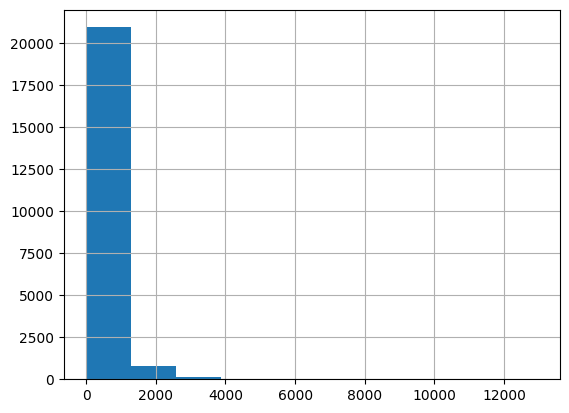

In [9]:
all_df['likes'].hist()


In [ ]:
all_df['likes_to_views_ratio'] = all_df['likes']/all_df['views']

In [10]:
all_df['log_likes'] = np.log(all_df.likes)

<Axes: >

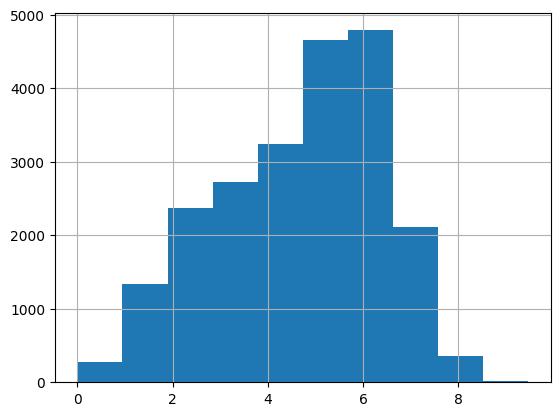

In [12]:
all_df.log_likes.hist()

## Importing data and concating on xthan json files

In [ ]:
##Preprocessing 1:
# We exrtact the categories of the items in the 'items' category. We ll use them later
# We can get the ratio of likes per views to get a better metric wheter the set is actually good or not
# We can then log it. First we the the ratio column and then we log it. Logging is the final step otherwise there is no differenece.
# Moreover we can cut the bottom %5 or some other ratio in order to get the outfits tha have been viewed a decemnt amount of times
#train_df['categories_list'] = train_df['items'].apply(lambda items_list: [item['categoryid'] for item in items_list])

#train_df['likes_to_views_ratio'] = train_df['likes']/train_df['views']

#train_df.drop(columns=(['items','image','set_url']),axis=1,inplace=True)

In [ ]:
##! OPTIONANL for testing
# #if we want to drop a percent of our dataset to crop the outliers
# lower_threshold = df['views'].quantile(0.05)
# upper_threshold = df['views'].quantile(0.95)
#np.log(train_df.likes/train_df.views).hist()
# df_filtered = train_df[(train_df['views'] >= lower_threshold) & (train_df['views'] <= upper_threshold)]


In [24]:
# importing the data from the tree different files
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/train_no_dup.json') as f:
    data1 = json.load(f)
train_df = pd.DataFrame(data1)

with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/test_no_dup.json') as f:
    data2 = json.load(f)
test_df = pd.DataFrame(data2)

with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/valid_no_dup.json') as f:
    data3 = json.load(f)
valid_df = pd.DataFrame(data3)

In [25]:
# We use this function to summarize all of our first steps of preprocessing
def preprocessing_1 (df):
    #creating a list with the number of the items
    df['categories_list'] = df['items'].apply(lambda items_list: [item['categoryid'] for item in items_list])
    #creating the target vector. Or we can simply leave the 'likes' vector as the target vector
    df['likes_to_views_ratio'] = df['likes']/df['views']
    #drop the extra columns we dont want anymore 
    df.drop(columns=(['image','set_url','date']),axis=1,inplace=True)
    #lower the description to extract later some text
    df.desc.str.lower()
    # lower the name
    df.name.str.lower()
    # deleting the punctuation from both the columns
    df.desc = df.desc.str.lower().str.replace('[{}]'.format(string.punctuation), ' ', regex=True)
    df.name = df.name.str.lower().str.replace('[{}]'.format(string.punctuation), ' ', regex=True)
    return df

In [26]:
all_df = pd.concat([train_df,test_df,valid_df],ignore_index=True)
all_df = preprocessing_1(all_df)

In [30]:
all_df.head(10)
            

,name,views,items,likes,set_id,desc,categories_list,likes_to_views_ratio
0,casual,8743,"[{'index': 1, 'name': 'mock neck embroidery su...",394,214181831,a fashion look from january 2017 by beebeely l...,"[4495, 25, 27, 261, 259, 1967, 2]",0.045065
1,being a vans shoe model with luke idk about t...,188,"[{'index': 1, 'name': 'nirvana distressed t-sh...",9,120161271,a fashion look from april 2014 featuring destr...,"[21, 237, 49, 106, 106, 106, 106, 106]",0.047872
2,these chanel bags is a bad habit x,562,"[{'index': 1, 'name': 'monki singlet', 'price'...",32,143656996,12 19 14,"[104, 25, 237, 261, 37, 55]",0.056940
3,avenger supernatural prp,2613,"[{'index': 1, 'name': 'tops', 'price': 18.0, '...",88,186627934,a fashion look from january 2016 by alyssaclai...,"[11, 28, 2, 65, 52, 200, 186, 76]",0.033678
4,boho 39,62,"[{'index': 1, 'name': 'yoins leather sexy v-ne...",3,206969379,a fashion look from august 2016 by kate goida ...,"[11, 236, 9, 261, 64, 62, 1967, 200]",0.048387
5,denim on denim,276,"[{'index': 1, 'name': 'new look light blue den...",83,201969694,a fashion look from june 2016 by sara 86 featu...,"[11, 241, 47, 37, 62, 196]",0.300725
6,the people i choose never choose me and my hea...,1580,"[{'index': 1, 'name': 'isabel marant alpaca bl...",395,216470135,a fashion look from february 2017 by exco feat...,"[19, 9, 41, 38, 62, 140, 4438]",0.250000
7,be happy,591,"[{'index': 1, 'name': 'oasis shadow bird knit ...",233,216220312,a fashion look from february 2017 by rasa j fe...,"[19, 8, 47, 38, 106, 222]",0.394247
8,enjoy your own company,1142,"[{'index': 1, 'name': 'valentino pleated cotto...",239,185225843,a fashion look from december 2015 by mcheffer ...,"[4, 17, 24, 43, 318, 105]",0.209282
9,yoins casual faux fur vest,24915,"[{'index': 1, 'name': 'yoins plus size blue st...",492,213824660,a fashion look from december 2016 by beebeely ...,"[11, 24, 237, 261, 58, 188, 171, 37]",0.019747


In [29]:
all_df['items'][5]

[{'index': 1,
  'name': 'new look light blue denim oversized long sleeve shirt',
  'price': 11.0,
  'likes': 5,
  'image': 'http://img1.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=174641775',
  'categoryid': 11,
  'item_id': '201969694_1'},
 {'index': 2,
  'name': 'mango skinny jane jegging',
  'price': 30.0,
  'likes': 59,
  'image': 'http://img2.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=176535125',
  'categoryid': 241,
  'item_id': '201969694_2'},
 {'index': 3,
  'name': 'sophia webster leather butterfly flats',
  'price': 350.0,
  'likes': 360,
  'image': 'http://img2.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=165020476',
  'categoryid': 47,
  'item_id': '201969694_3'},
 {'index': 4,
  'name': 'michael michael kors mini selma crossbody bag',
  'price': 150.0,
  'likes': 7013,
  'image': 'http://img1.polyvoreimg.com/cgi/img-thing?.out=jpg&size=m&tid=141342171',
  'categoryid': 37,
  'item_id': '201969694_4'},
 {'index': 5,
  'name': 'velvet vase embellished neckl

In [28]:
# We create a new dictionary value for every item in the dictionary 
# with item_id which is the set_id concatenated with the index
# In this way every item will have its unique id number but will know in which set belongs
for index, row in all_df.iterrows():
    updated_items = []
    for item in row['items']:
        item['item_id'] = f"{row['set_id']}_{item['index']}"
        updated_items.append(item)
    all_df.at[index, 'items'] = updated_items

In [31]:
# Here we delete the values in the dictionaries of the imtes that we wont use anymore. We keep only index, categoryid, item_id
for index, row in all_df.iterrows():
    updated_items = []
    for item in row['items']:
        # Create a new dictionary with only desired columns
        new_item = {
            'index': item['index'],
            'categoryid': item['categoryid'],
            'likes': item['likes'],
            'item_id': f"{row['set_id']}_{item['index']}"
        }
        updated_items.append(new_item)
    all_df.at[index, 'items'] = updated_items

In [32]:
all_df['items'][5]

[{'index': 1, 'categoryid': 11, 'likes': 5, 'item_id': '201969694_1'},
 {'index': 2, 'categoryid': 241, 'likes': 59, 'item_id': '201969694_2'},
 {'index': 3, 'categoryid': 47, 'likes': 360, 'item_id': '201969694_3'},
 {'index': 4, 'categoryid': 37, 'likes': 7013, 'item_id': '201969694_4'},
 {'index': 5, 'categoryid': 62, 'likes': 1325, 'item_id': '201969694_5'},
 {'index': 6, 'categoryid': 196, 'likes': 142, 'item_id': '201969694_6'}]

In [ ]:
# # ways to find common elements between two dataframes according to the set_id
# a = all_df.set_id
# b = all_df.set_id

# # First way with sets
# set1 = set(a)
# set2 = set(b)
# common_elements = list(set1 & set2)
# # Second way with intesect function
# def common_member(a, b):
#     return list(np.intersect1d(a, b))
# # Third way with list comprehension
# common_elements = list(filter(lambda elem: elem in a, b))

## EXTRACTING MENS OUTFITS

In [9]:
#### STEP 1 : We try to find the outfits that may belong to mens fashion


# Our goal is to filter the outfits. Firstly we will try to extract the outfits tha may belonging to mens fashion
# In order to do it we locate the categories that refer to mens fashion according to the txt file.
# Then we try extracting inforamtion on the string columns (describe and name) 
# Initially we check for the outfits that may belong to men fashion
men_subcategories = [343,272,273,275,276,277,278,279,280,281,282,283,284,286,287,288,289,290,291,
                     292,293,294,295,296,297,298,299,300,301,302,303,304,305,342,4447,4454,4455,
                     4456,4457,4458,4459,4460,4461,4462,4463,4464,4465,4466,4467,4472,4474,4497,
                     4498,4520,4521,4522,4523,4524,4525,341]

In [ ]:
####### OPTIONAL: Here we check the index and the elements that are common betwwen the men_categories
# that are items for men fashion and the categories_list where there are the items in form of list of numbers
def common_member(a, b):
    return list(np.intersect1d(a, b))
# Third way with list comprehension

# Checking if there is 
men_fashion = []
count = 0
for i in range(0,len(all_df)):
    b = all_df['categories_list'][i]
    common_elements = common_member(men_subcategories, b)

    if not common_elements:
        continue
    else:    
        print("Index is: ",i, common_elements)
        count = count +1
        men_fashion.append(all_df['set_id'][i])

In [50]:
def has_common_elements(row):
    row_set = set(row['categories_list'])
    return bool(row_set.intersection(men_subcategories))

In [51]:
men_df_lists = all_df.copy()
men_df_NLP_name = all_df.copy()
men_df_NLP_desc = all_df.copy()


In [52]:
# in this list we keep the rows that have at least one common element with the list that has men items
men_df_lists = men_df_lists[men_df_lists.apply(has_common_elements, axis=1)]
# here we find any row that may have the words man, men, menswear in the name tag
men_df_NLP_name = men_df_NLP_name[men_df_NLP_name.name.str.contains(r'\b(men|man|menswear)\b', case=False)]
# same we try to find any rows that have description with men, man, menswear in them
men_df_NLP_desc = men_df_NLP_desc[men_df_NLP_desc.desc.str.contains(r'\b(men|man|menswear)\b', case=False)]

In [69]:
# we merge all the data frames
merged_df = pd.concat([men_df_lists, men_df_NLP_name, men_df_NLP_desc],ignore_index=True)
# we drop any dublicate rows that may have been arised
merged_df = merged_df.drop_duplicates(subset='set_id')

In [78]:
merged_df

,name,views,likes,set_id,desc,categories_list,likes_to_views_ratio
0,281 gt solivagant,851,118,191351163,a fashion look from february 2016 by dimibra f...,"[11, 25, 237, 46, 37, 64, 303]",0.138660
1,dylan o brien ii,893,31,132081114,dylan o brien dylanobrien teenwolf,"[40, 275, 283, 297, 300, 95, 316, 1967]",0.034714
2,a preppy life,8,7,214229253,a menswear look from january 2017 by luvadalov...,"[342, 4458, 295, 305, 4520, 4463, 303, 4472]",0.875000
3,sin título 63,169,20,106355827,a fashion look from december 2013 featuring ta...,"[104, 237, 318, 61, 106, 55, 297, 199]",0.118343
4,ignore unless tagged,295,38,213960031,a menswear look from december 2016 by lightyea...,"[275, 278, 4456, 297, 56]",0.128814
...,...,...,...,...,...,...,...
1786,plaid shorts,20,9,213101840,a menswear look from december 2016 by babiessw...,"[49, 102, 102, 102]",0.450000
1787,printed shorts,27,15,212931654,a menswear look from december 2016 by babiessw...,"[11, 2, 102, 4441]",0.555556
1794,plain boy,323,44,198451881,a menswear look from may 2016 featuring turtle...,"[11, 24, 49, 77]",0.136223
1797,little black dress and cardigan 18,807,544,207701263,a menswear look from september 2016 by ermanso...,"[43, 4, 36, 62, 18]",0.674102


In [90]:
# we want to find the dataframe without the rows of the mens fashino dataset we created above
condition = all_df['set_id'].isin(merged_df['set_id'])
all_df_no_men_outfits = all_df[~condition]
all_df_no_men_outfits

## STEP EXTRACTING OUTFITS BASED ON OUR FORMS

In [33]:
###### STEP 2: We try to find the outfits tha have the form we want without missing any other items


# Every number corresponds to a subcategory listed in a txt file in the dataset
# Then we map these subcategories to our categories
category_mapping = {
"Tops": [11, 15, 17,18,19,21,343,104,252,272,273,275,286,309,342,4454,4495,4496, 4497, 4498, 341 ],

"Bottoms": [7, 8, 9, 10, 27, 28, 29, 237, 238, 239, 240, 241, 251, 253, 254, 255, 278, 279, 280, 287, 288, 4452, 4458, 4459, 332],

"Accessories": [40, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 64, 65, 67, 105, 106, 107, 270, 299, 300, 301, 302, 303, 304, 305, 4447, 4463, 4466, 4467, 4470, 4472, 4523, 4524, 4525, 1967],

"Shoes": [41, 42, 43, 46, 47, 48, 49, 50, 261, 262, 263, 264, 265, 266, 267, 268, 291, 292, 293, 294, 295, 296, 297, 298, 4464, 4465, 4522],

"Outwear": [23, 24, 25, 26, 256, 276, 277, 289, 4455, 4457, 4456,236 ],

"Bags": [35, 36, 37, 38, 231, 258, 259, 290, 4461, 4462, 4474, 4520, 4521],

"Onepieces": [3, 4, 5, 6, 30, 75, 243, 244, 281, 4486, 4516, 1606, 1607]}

In [34]:
# Function to replace the numbers in the lists of "categories_list" column with the 
# corresponding Class name string according to the category_mapping dictionary
def replace_codes_with_names(codes):
    new_list = []
    for code in codes:
        for category, mappings in category_mapping.items():
            if code in mappings:
                new_list.append(category)
                break
        else:
            new_list.append("Other")  # If the code is not found in any mapping, tag it as "Other"
    return new_list

In [35]:
all_df['category_names'] = all_df['categories_list'].apply(replace_codes_with_names)


In [ ]:
# Here we try to create a new value for every item in the dictionaries in "items" that has the name of the category
# We will use it later to extract proper outfits
def find_category_name(categoryid):
    for category_name, ids in category_mapping.items():
        if categoryid in ids:
            return category_name
    return "Other"
# Update the items column to include category_name
for idx, row in all_df.iterrows():
    for item in row['items']:
        item['category_name'] = find_category_name(item['categoryid'])
    all_df.at[idx, 'items'] = row['items']

In [36]:
all_df.head(10)

,name,views,items,likes,set_id,desc,categories_list,likes_to_views_ratio,category_names
0,casual,8743,"[{'index': 1, 'categoryid': 4495, 'likes': 10,...",394,214181831,a fashion look from january 2017 by beebeely l...,"[4495, 25, 27, 261, 259, 1967, 2]",0.045065,"[Tops, Outwear, Bottoms, Shoes, Bags, Accessor..."
1,being a vans shoe model with luke idk about t...,188,"[{'index': 1, 'categoryid': 21, 'likes': 1290,...",9,120161271,a fashion look from april 2014 featuring destr...,"[21, 237, 49, 106, 106, 106, 106, 106]",0.047872,"[Tops, Bottoms, Shoes, Accessories, Accessorie..."
2,these chanel bags is a bad habit x,562,"[{'index': 1, 'categoryid': 104, 'likes': 2009...",32,143656996,12 19 14,"[104, 25, 237, 261, 37, 55]",0.056940,"[Tops, Outwear, Bottoms, Shoes, Bags, Accessor..."
3,avenger supernatural prp,2613,"[{'index': 1, 'categoryid': 11, 'likes': 2036,...",88,186627934,a fashion look from january 2016 by alyssaclai...,"[11, 28, 2, 65, 52, 200, 186, 76]",0.033678,"[Tops, Bottoms, Other, Accessories, Accessorie..."
4,boho 39,62,"[{'index': 1, 'categoryid': 11, 'likes': 6637,...",3,206969379,a fashion look from august 2016 by kate goida ...,"[11, 236, 9, 261, 64, 62, 1967, 200]",0.048387,"[Tops, Outwear, Bottoms, Shoes, Accessories, A..."
5,denim on denim,276,"[{'index': 1, 'categoryid': 11, 'likes': 5, 'i...",83,201969694,a fashion look from june 2016 by sara 86 featu...,"[11, 241, 47, 37, 62, 196]",0.300725,"[Tops, Bottoms, Shoes, Bags, Accessories, Other]"
6,the people i choose never choose me and my hea...,1580,"[{'index': 1, 'categoryid': 19, 'likes': 268, ...",395,216470135,a fashion look from february 2017 by exco feat...,"[19, 9, 41, 38, 62, 140, 4438]",0.250000,"[Tops, Bottoms, Shoes, Bags, Accessories, Othe..."
7,be happy,591,"[{'index': 1, 'categoryid': 19, 'likes': 4874,...",233,216220312,a fashion look from february 2017 by rasa j fe...,"[19, 8, 47, 38, 106, 222]",0.394247,"[Tops, Bottoms, Shoes, Bags, Accessories, Other]"
8,enjoy your own company,1142,"[{'index': 1, 'categoryid': 4, 'likes': 73, 'i...",239,185225843,a fashion look from december 2015 by mcheffer ...,"[4, 17, 24, 43, 318, 105]",0.209282,"[Onepieces, Tops, Outwear, Shoes, Other, Acces..."
9,yoins casual faux fur vest,24915,"[{'index': 1, 'categoryid': 11, 'likes': 94, '...",492,213824660,a fashion look from december 2016 by beebeely ...,"[11, 24, 237, 261, 58, 188, 171, 37]",0.019747,"[Tops, Outwear, Bottoms, Shoes, Accessories, O..."


In [45]:
form1 = {'Tops', 'Bottoms', 'Shoes', 'Bags', 'Accessories', 'Outwear'}
form2 = {'Onepieces', 'Shoes', 'Bags', 'Accessories', 'Outwear'}
form1_no_outerwear = form1 - {'Outwear'}
form2_no_outerwear = form2 - {'Outwear'}
# Function to filter rows based on forms WITH Outerwears
def filter_rows_WITH_outerwear(categories):
    # Exclude "Other" from the categories
    category_set = set(categories) - {'Other'}
    return category_set == form1 or category_set == form2
# Function to filter rows based on forms WITH NO Outerwears
def filter_rows_NO_outerwear(categories):
    # Exclude "Other" from the categories
    form1 
    category_set = set(categories) - {'Other','Outerwear'}
    return category_set == form1_no_outerwear or category_set == form2_no_outerwear

In [111]:
all_df_NO_Outerwear = all_df.copy()
all_df_WITH_Outerwear = all_df.copy()
all_df_WITH_Outerwear = all_df_WITH_Outerwear[all_df_WITH_Outerwear['category_names'].apply(filter_rows_WITH_outerwear)]
all_df_NO_Outerwear = all_df_NO_Outerwear[all_df_NO_Outerwear['category_names'].apply(filter_rows_NO_outerwear)]

In [68]:
all_df_WITH_Outerwear

,name,views,items,likes,set_id,desc,categories_list,likes_to_views_ratio,category_names
0,casual,8743,"[{'index': 1, 'categoryid': 4495, 'likes': 10,...",394,214181831,a fashion look from january 2017 by beebeely l...,"[4495, 25, 27, 261, 259, 1967, 2]",0.045065,"[Tops, Outwear, Bottoms, Shoes, Bags, Accessor..."
2,these chanel bags is a bad habit x,562,"[{'index': 1, 'categoryid': 104, 'likes': 2009...",32,143656996,12 19 14,"[104, 25, 237, 261, 37, 55]",0.056940,"[Tops, Outwear, Bottoms, Shoes, Bags, Accessor..."
9,yoins casual faux fur vest,24915,"[{'index': 1, 'categoryid': 11, 'likes': 94, '...",492,213824660,a fashion look from december 2016 by beebeely ...,"[11, 24, 237, 261, 58, 188, 171, 37]",0.019747,"[Tops, Outwear, Bottoms, Shoes, Accessories, O..."
16,edgy style,1218,"[{'index': 1, 'categoryid': 5, 'likes': 18, 'i...",328,215293689,a fashion look from january 2017 by pokadoll f...,"[5, 25, 2, 261, 38, 62, 200]",0.269294,"[Onepieces, Outwear, Other, Shoes, Bags, Acces..."
18,без названия 322,1341,"[{'index': 1, 'categoryid': 21, 'likes': 622, ...",212,152669888,a fashion look from march 2015 featuring rolle...,"[21, 25, 240, 49, 37, 4438, 2, 67]",0.158091,"[Tops, Outwear, Bottoms, Shoes, Bags, Other, O..."
...,...,...,...,...,...,...,...,...,...
21830,flounce ruffles checked straight dress,1348,"[{'index': 1, 'categoryid': 4, 'likes': 27, 'i...",538,214555487,a fashion look from january 2017 by katjuncica...,"[4, 25, 261, 261, 65, 259]",0.399110,"[Onepieces, Outwear, Shoes, Shoes, Accessories..."
21860,yoins 20 08 2016 083,461,"[{'index': 1, 'categoryid': 5, 'likes': 449, '...",134,206332537,a fashion look from august 2016 by aysebt feat...,"[5, 25, 43, 43, 37, 62, 196, 196]",0.290672,"[Onepieces, Outwear, Shoes, Shoes, Bags, Acces..."
21871,casual,4877,"[{'index': 1, 'categoryid': 19, 'likes': 3, 'i...",384,213826418,a fashion look from december 2016 by beebeely ...,"[19, 25, 237, 49, 259, 40, 60, 3336]",0.078737,"[Tops, Outwear, Bottoms, Shoes, Bags, Accessor..."
21877,outfit of the day,1019,"[{'index': 1, 'categoryid': 17, 'likes': 43, '...",214,216860218,a fashion look from february 2017 by dressedby...,"[17, 236, 28, 46, 37, 64, 65, 65]",0.210010,"[Tops, Outwear, Bottoms, Shoes, Bags, Accessor..."


In [83]:
all_df_WITH_Outerwear['items'][20]

[{'index': 1,
  'categoryid': 5,
  'likes': 5946,
  'item_id': '212866780_1',
  'category_name': 'Onepieces'},
 {'index': 2,
  'categoryid': 24,
  'likes': 2377,
  'item_id': '212866780_2',
  'category_name': 'Outwear'},
 {'index': 3,
  'categoryid': 43,
  'likes': 1019,
  'item_id': '212866780_3',
  'category_name': 'Shoes'},
 {'index': 4,
  'categoryid': 36,
  'likes': 7420,
  'item_id': '212866780_4',
  'category_name': 'Bags'},
 {'index': 5,
  'categoryid': 65,
  'likes': 4632,
  'item_id': '212866780_5',
  'category_name': 'Accessories'},
 {'index': 6,
  'categoryid': 64,
  'likes': 3188,
  'item_id': '212866780_6',
  'category_name': 'Accessories'},
 {'index': 7,
  'categoryid': 95,
  'likes': 413,
  'item_id': '212866780_7',
  'category_name': 'Other'},
 {'index': 8,
  'categoryid': 74,
  'likes': 2594,
  'item_id': '212866780_8',
  'category_name': 'Other'}]

In [110]:
# delete the items in the "items" columns that have the "Other tag". We dont want the items tha belong to these categories.
def preprocessing_2(df):
    
    for idx, row in df.iterrows():
        updated_items = [item for item in row['items'] if item['category_name'] != "Other"]
        df.at[idx, 'items'] = updated_items
         
    for idx, row in df.iterrows():
        # Dictionary to hold the item with the most likes for each category
        max_likes_items = {}
        
        # Iterate over items and keep track of the item with the maximum likes for each category
        for item in row['items']:
            category = item['category_name']
            likes = item['likes']
            
            # If the category is not seen before or the current item has more likes, update the dictionary
            if category not in max_likes_items or likes > max_likes_items[category]['likes']:
                max_likes_items[category] = item

        # Update the items column with the desired items
        df.at[idx, 'items'] = list(max_likes_items.values())   
        # We overwite the previous 'category_name' because we wont use it anymore
        df['category_names'] = df['items'].apply(lambda x: list({item['category_name'] for item in x}))
        # Creating a column with the length of the items in the list of dictionaries.
        df["length_of_category_name"] = df['items'].apply(len)       
    return df

In [91]:
# Here we want to find if there are more than one items in the "items" column that have the same category_name.
# We want to have exact one item from every category in our form1 or form2. In case we have more than one item we keep the one with more likes.

# Process each row in the DataFrame
def remove_items_in_same_category(df): 
    for idx, row in df.iterrows():
        # Dictionary to hold the item with the most likes for each category
        max_likes_items = {}
        
        # Iterate over items and keep track of the item with the maximum likes for each category
        for item in row['items']:
            category = item['category_name']
            likes = item['likes']
            
            # If the category is not seen before or the current item has more likes, update the dictionary
            if category not in max_likes_items or likes > max_likes_items[category]['likes']:
                max_likes_items[category] = item

        # Update the items column with the desired items
        df.at[idx, 'items'] = list(max_likes_items.values())
    return df

In [112]:
all_df_WITH_Outerwear = preprocessing_2(all_df_WITH_Outerwear)
all_df_NO_Outerwear = preprocessing_2(all_df_NO_Outerwear)


In [115]:
Outerwear_Onepiece = all_df_WITH_Outerwear[all_df_WITH_Outerwear['length_of_category_name'] == 5]
Outerwear_NO_Onepiece = all_df_WITH_Outerwear[all_df_WITH_Outerwear['length_of_category_name'] == 6]


In [116]:
NO_Outerwear_Onepiece = all_df_NO_Outerwear[all_df_NO_Outerwear['length_of_category_name'] == 4]
NO_Outerwear_NO_Onepiece = all_df_NO_Outerwear[all_df_NO_Outerwear['length_of_category_name'] == 5]
